# **PROJECT OBJECTIVE:** *Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.*

In [1]:
from google.colab import drive  
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
#Importing all the necessary libraries
import os
import string
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # To ignore any warnings

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Performance Metrics

from wordcloud import WordCloud # To display WordCloud

# Tensorflow Library
import tensorflow as tf

print(tf.__version__)

2.5.0


In [3]:
project_path = r"/content/drive/MyDrive/Great_Learning/NLP/Sequential_NLP_Project/Project_2"
os.chdir(project_path)
os.getcwd()

'/content/drive/MyDrive/Great_Learning/NLP/Sequential_NLP_Project/Project_2'

## 1. Read and explore the data.

In [4]:
data_src = 'https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json'

data_raw = pd.read_json(data_src, lines=True)
data_raw.sample(5)

,is_sarcastic,headline,article_link
25813,1,chechen infant lulled to sleep by distant rumb...,https://www.theonion.com/chechen-infant-lulled...
6410,0,suspect in kim jong nam's murder also sickened...,https://www.huffingtonpost.com/entry/kim-jong-...
6748,1,cbs reveals 'big bang theory' season 12 will e...,https://entertainment.theonion.com/cbs-reveals...
19745,0,st. louis cardinals fans have a seriously raci...,https://www.huffingtonpost.com/entry/st-louis-...
21164,0,if you don't think paul manafort can get trump...,https://www.huffingtonpost.comhttp://www.slate...


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
# Checking for missing values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

missing_zero_values_table(data_raw)

Your selected dataframe has 3 columns and 28619 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


### Inference:- NO missing values found in this dataset.

In [7]:
data_raw['source'] = data_raw['article_link'].apply(lambda x: re.findall(r'\w+', x)[2]) # Seperating source from the article_link
data_raw.head()

,is_sarcastic,headline,article_link,source
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion


Labels details and plot:-
------------------------------
0    14985
1    13634
Name: is_sarcastic, dtype: int64
------------------------------


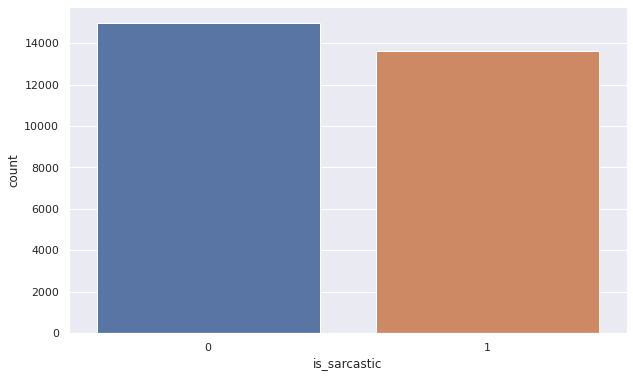

In [8]:
print("Labels details and plot:-")
print("-" * 30)
print(data_raw['is_sarcastic'].value_counts())
print("-" * 30)

plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.countplot(data_raw['is_sarcastic'])

### Inference:- Unsarcastic data is slightly more than sarcastic one's but overall the dataset is balanced.

Source details and plot:-
------------------------------
huffingtonpost    14985
theonion          13634
Name: source, dtype: int64
------------------------------


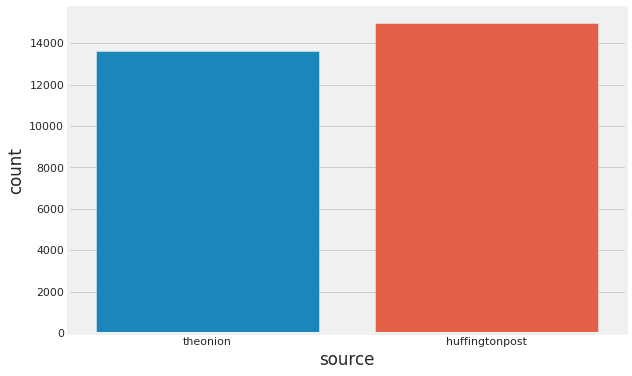

In [9]:
print("Source details and plot:-")
print("-" * 30)
print(data_raw['source'].value_counts())
print("-" * 30)

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
sns.countplot(data_raw['source'])

### Inference:- All of unsarcastic data comes from huffingpost and sarcatic one's comes from theonion.

## 2. Retain relevant columns.

In [10]:
data = pd.DataFrame({'Features': data_raw['headline'], 'Labels': data_raw['is_sarcastic']}) #Creating new DataFrame with relevant columns only
data.sample(5)

,Features,Labels
3507,violinist sick of doing mozart covers,1
1565,man beaten to bloody pulp after allegedly rapi...,0
13,chris christie suggests hillary clinton was to...,0
12031,michael phelps recreates his 'angry michael ph...,0
14019,obama administration warns schools to allow tr...,0


Unsarcastic WordCloud
------------------------------


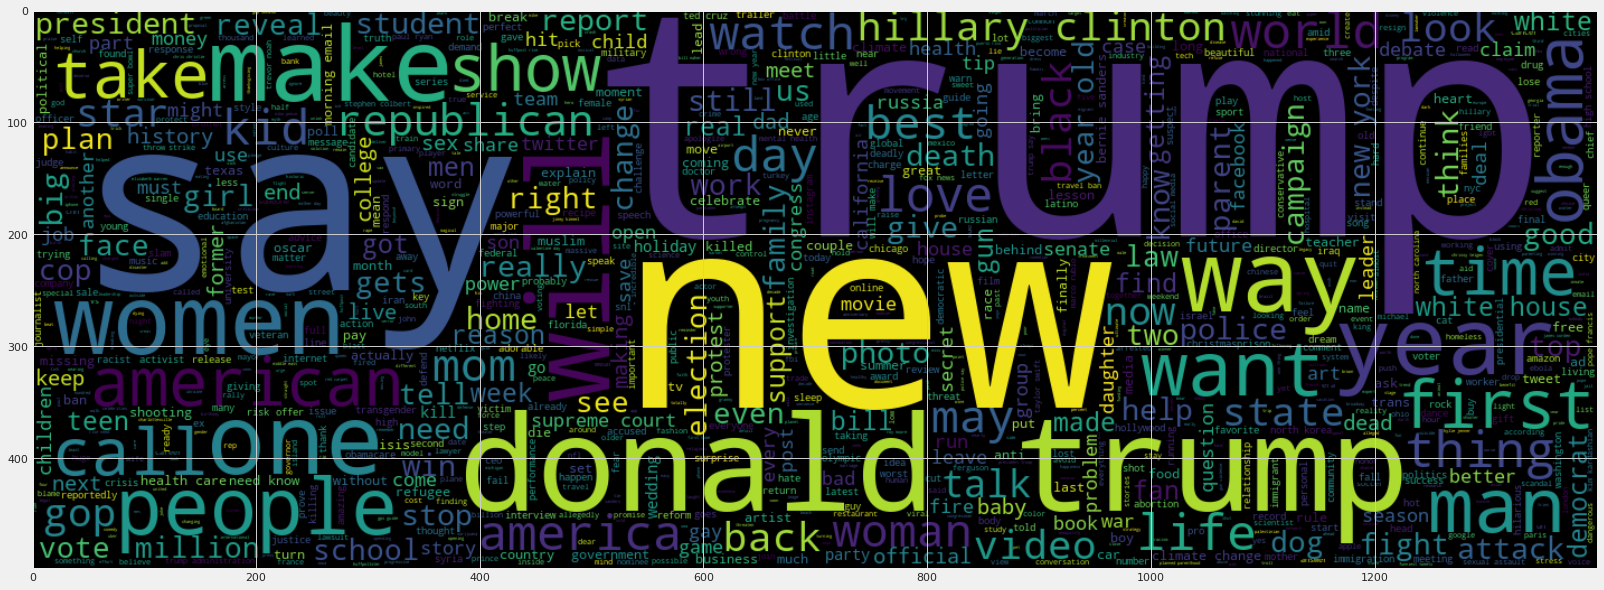

In [11]:
# Unsarcastic WordCloud
print("Unsarcastic WordCloud")
print("-" * 30)
plt.figure(figsize=(25,25))
wordcloud = WordCloud(max_words = 1000, width = 1400, height=500).generate(" ".join(data[data.Labels==0].Features))
plt.imshow(wordcloud,interpolation='bilinear')

Sarcastic WordCloud
------------------------------


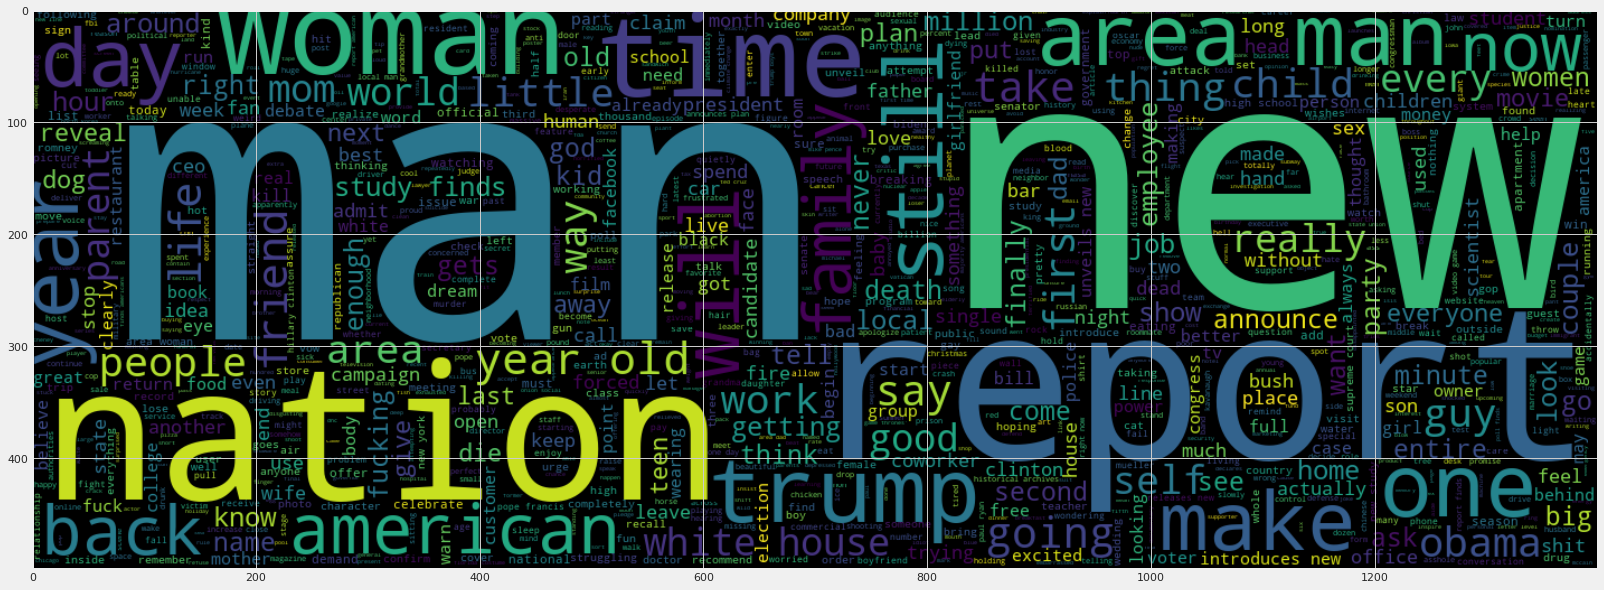

In [12]:
# Sarcastic WordCloud
print("Sarcastic WordCloud")
print("-" * 30)
plt.figure(figsize=(25,25))
wordcloud = WordCloud(max_words = 1000, width = 1400, height=500).generate(" ".join(data[data.Labels==1].Features))
plt.imshow(wordcloud,interpolation='bilinear')

## 3. Get length of each sentence.

In [13]:
# Capturing each sentence lengths
data_raw['sentences_lengths'] = data_raw['headline'].apply(lambda x: len(x))
data_raw.head(5)

,is_sarcastic,headline,article_link,source,sentences_lengths
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion,61
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost,79
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost,49
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion,52
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion,61


In [14]:
# Sentence length statistics
data_raw['sentences_lengths'].describe()

count    28619.000000
mean        62.308571
std         20.726483
min          7.000000
25%         49.000000
50%         62.000000
75%         75.000000
max        926.000000
Name: sentences_lengths, dtype: float64

### Inferences:-
### 1. The length of headlines ranges between 7 and 926. 
### 2. Mean and Standard deviation is around 62. As they are same the distribution will be a normal distribution.
### 3. There's a huge difference between the third quartile and max value which suggests presences of large numbers of outliers.
 

[Text(0.5, 0, 'Sentence Lengths')]

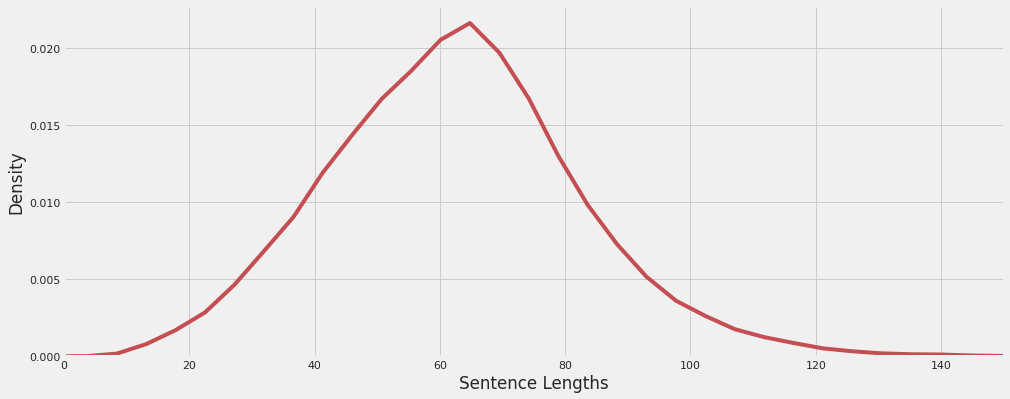

In [15]:
# PLotting sentence length distribution
plt.figure(figsize=(15,6))
plt.xlim(0, 150)

ax = sns.distplot(data_raw['sentences_lengths'], hist=False, color="r")
ax.set(xlabel='Sentence Lengths')

### Inferences:-
### 1. Max count of sentence lengths lies between  20 and 120.
### 2. Hence we can take 120 or anything between the above range as max_len parameter for pad_sequence.

## 4. Define parameters.

In [16]:
# Hyperparameters
vocab_size = 30000
oov_token = '<00V>'
max_length = 100
padding_type = 'post'
trunc_type = 'post'
embedding_dim = 100
batch_size = 256
num_epochs = 30

## 5. Get indices for words.

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(data['Features'])
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(data['Features'])

print("Indices for words:- ", word_index)
print('-' * 25)
print("Tokenized samples: ")
print('-' * 25)
print(X[0])

Indices for words:-  {'<00V>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'trump': 13, 'man': 14, 'at': 15, 'from': 16, 'about': 17, 'by': 18, 'after': 19, 'you': 20, 'this': 21, 'out': 22, 'up': 23, 'be': 24, 'as': 25, 'that': 26, 'it': 27, 'how': 28, 'not': 29, 'he': 30, 'his': 31, 'are': 32, 'your': 33, 'just': 34, 'what': 35, 'all': 36, 'who': 37, 'has': 38, 'will': 39, 'report': 40, 'into': 41, 'more': 42, 'one': 43, 'have': 44, 'year': 45, 'over': 46, 'why': 47, 'day': 48, 'u': 49, 'area': 50, 'woman': 51, 'can': 52, 's': 53, 'says': 54, 'donald': 55, 'time': 56, 'first': 57, 'like': 58, 'no': 59, 'her': 60, 'get': 61, 'off': 62, 'old': 63, "trump's": 64, 'life': 65, 'now': 66, 'people': 67, "'": 68, 'an': 69, 'house': 70, 'still': 71, 'obama': 72, 'white': 73, 'back': 74, 'make': 75, 'was': 76, 'than': 77, 'women': 78, 'if': 79, 'down': 80, 'when': 81, 'i': 82, 'my': 83, '5': 84, 'clinton': 85, 'could': 86, 'they

In [18]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('-' * 25)
print("Padded sample: ")
print('-' * 25)
print(X[0])

-------------------------
Padded sample: 
-------------------------
[16004   355  3167  7474  2644     3   661  1119     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


## 6. Create features and labels.

In [19]:
print("No. of Features: ", len(X))
print('-' * 25)
print(X[0])

y = np.asarray(data['Labels'])

print("Number of Labels: ", len(y))
print('-' * 25)
print(y[0])

No. of Features:  28619
-------------------------
[16004   355  3167  7474  2644     3   661  1119     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Number of Labels:  28619
-------------------------
1


## 7. Get vocabulary size.

In [20]:
# Vocabulary Size
num_words = len(tokenizer.word_index) + 1
print(" Total no. of words in tokenizer: ", num_words)

 Total no. of words in tokenizer:  30886


## 8. Create a weight matrix using GloVe embeddings.

In [21]:
embeddings = {}
for g in open('glove.6B.100d.txt'):
  word = g.split(" ")[0]
  embd = g.split(" ")[1:]
  embd = np.asarray(embd, dtype=np.float32)
  embeddings[word] = embd

In [22]:
print("Length of embeddings: ", len(embeddings.values()))

Length of embeddings:  400000


In [23]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [24]:
print("Shape of embedding matrix : ", embedding_matrix.shape)

Shape of embedding matrix :  (30886, 100)


In [25]:
print("Embedding Matrix sample: ")
embedding_matrix[5]

Embedding Matrix sample: 


array([ 0.085703  , -0.22201   ,  0.16569   ,  0.13372999,  0.38238999,
        0.35400999,  0.01287   ,  0.22461   , -0.43816999,  0.50164002,
       -0.35874   , -0.34983   ,  0.055156  ,  0.69647998, -0.17958   ,
        0.067926  ,  0.39100999,  0.16039   , -0.26635   , -0.21138   ,
        0.53697997,  0.49379   ,  0.93660003,  0.66902   ,  0.21793   ,
       -0.46641999,  0.22383   , -0.36204001, -0.17656   ,  0.17479999,
       -0.20367   ,  0.13931   ,  0.019832  , -0.10413   , -0.20243999,
        0.55002999, -0.15459999,  0.98654997, -0.26863   , -0.29089999,
       -0.32866001, -0.34187999, -0.16943   , -0.42001   , -0.046727  ,
       -0.16327   ,  0.70823997, -0.74910998, -0.091559  , -0.96178001,
       -0.19746999,  0.10282   ,  0.55220997,  1.38160002, -0.65635997,
       -3.25020003, -0.31556001, -1.20550001,  1.77090001,  0.40259999,
       -0.79826999,  1.15970004, -0.33041999,  0.31382   ,  0.77385998,
        0.22595   ,  0.52471   , -0.034053  ,  0.32047999,  0.07

## 9. Define and compile a Bidirectional LSTM model.

In [26]:
y = y.reshape(-1,1)

In [27]:
# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 10, test_size = 0.3, stratify = y)

In [28]:
# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

In [29]:
print("Shape of Training Data: ", X_train.shape)
print('-' * 30)
print("Shape of Testing Data: ", X_test.shape)

Shape of Training Data:  (20033, 100)
------------------------------
Shape of Testing Data:  (8586, 100)


In [30]:
# Base Model Architechture
tf.keras.backend.clear_session() # Clear previous session
base_model = tf.keras.models.Sequential() # Model instantiation
base_model.add(tf.keras.layers.Embedding(num_words, embedding_dim, weights = [embedding_matrix], input_length=max_length)) #Input Layer
base_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))) # Bidirectional LSTM Layer
base_model.add(tf.keras.layers.GlobalAveragePooling1D())
base_model.add(tf.keras.layers.Dense(32, activation='relu'))
base_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Output Layer

In [31]:
# Compiling the model
base_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
# Model Summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3088600   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          84480     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,177,241
Trainable params: 3,177,241
Non-trainable params: 0
_________________________________________________________________


## 10. Fit the model and check the validation accuracy.

In [32]:
mc = tf.keras.callbacks.ModelCheckpoint('base_model_best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)

In [33]:
base_history = base_model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, callbacks=[mc, es], validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
79/79 [==============================] - 59s 701ms/step - loss: 0.5744 - accuracy: 0.6907 - val_loss: 0.4354 - val_accuracy: 0.8044

Epoch 00001: val_accuracy improved from -inf to 0.80445, saving model to base_model_best.hdf5
Epoch 2/30
79/79 [==============================] - 55s 693ms/step - loss: 0.3530 - accuracy: 0.8505 - val_loss: 0.3512 - val_accuracy: 0.8428

Epoch 00002: val_accuracy improved from 0.80445 to 0.84277, saving model to base_model_best.hdf5
Epoch 3/30
79/79 [==============================] - 55s 692ms/step - loss: 0.2416 - accuracy: 0.9055 - val_loss: 0.3390 - val_accuracy: 0.8542

Epoch 00003: val_accuracy improved from 0.84277 to 0.85418, saving model to base_model_best.hdf5
Epoch 4/30
79/79 [==============================] - 54s 690ms/step - loss: 0.1772 - accuracy: 0.9359 - val_loss: 0.3817 - val_accuracy: 0.8475

Epoch 00004: val_accuracy did not improve from 0.85418
Epoch 5/30
79/79 [==============================] - 55s 693ms/step - loss: 0.1184

In [34]:
base_model_best = tf.keras.models.load_model('base_model_best.hdf5')

In [35]:
# Predicting for all of test dataset 
base_predictions = base_model_best.predict(X_test, batch_size=1024).round().astype(int)
base_predictions[0]

array([1])

In [36]:
# Inversing probability into test labels
rounded = [np.round(x[0]) for x in base_predictions]
base_predictions = rounded

Text(0.5, 1.0, 'Accuracy Score: 0.8647798742138365')

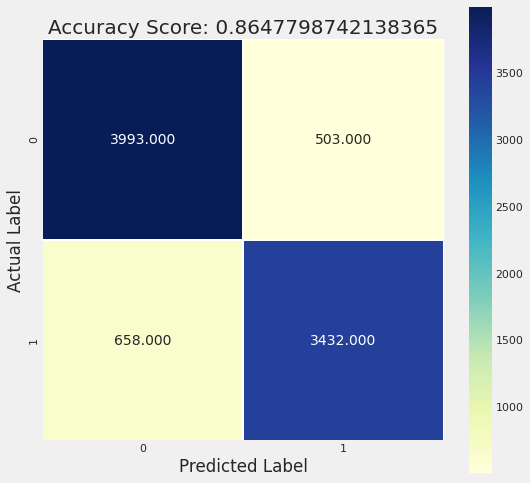

In [50]:
# Confusion Matrix

cm = confusion_matrix(y_test,base_predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap="YlGnBu")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,base_predictions))
plt.title(all_sample_title, size = 20)

### Inferences:-
### 1. 503 labels are wrongly classified in unsarcastic headlines
### 2. 658 labels are wrongly classified in sarcastic headlines.

In [38]:
# Classification Report
print(classification_report(y_test, base_predictions, target_names = ['Unsarcastic','Sarcastic']))

              precision    recall  f1-score   support

 Unsarcastic       0.86      0.89      0.87      4496
   Sarcastic       0.87      0.84      0.86      4090

    accuracy                           0.86      8586
   macro avg       0.87      0.86      0.86      8586
weighted avg       0.87      0.86      0.86      8586



### Inference:- f1-score for unsarcatic is slightly better than sarcastic.

In [39]:
# Plotting History
def plot_history(history):
    # Storing Accuracies and Losses data of Training and Validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    # Features settings for plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch ==>')
    plt.ylabel('Accuracy (%) ==>')
    plt.plot(x, acc, 'c', label='Training acc')
    plt.plot(x, val_acc, 'm', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch ==>')
    plt.ylabel('Loss ==>')
    plt.plot(x, loss, 'c', label='Training loss')
    plt.plot(x, val_loss, 'm', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

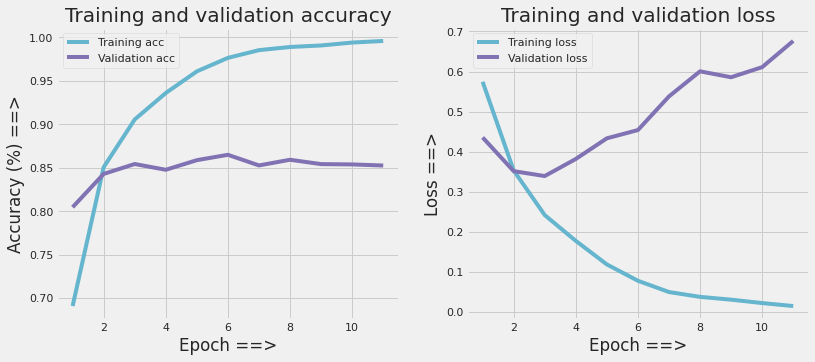

In [40]:
plot_history(base_history)

### Inferences:-
### 1. The above base model is strongly overfitting.
### 2. Training model has good learning rate but validation model has very high learning rate.

## Training a second model with extra dense layers, L2 penalties and different learning rate for optimizer for reducing the overfitting of model.

In [41]:
# Base Model Architechture
tf.keras.backend.clear_session() # Clear previous session
model = tf.keras.models.Sequential() # Model instantiation
model.add(tf.keras.layers.Embedding(num_words, embedding_dim, weights = [embedding_matrix], input_length=max_length)) #Input Layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))) # Bidirectional LSTM Layer
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l=0.01))) # kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.01)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l=0.01)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l=0.01)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Output Layer

In [42]:
# Compiling the model
adam_opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam_opt, metrics=['accuracy'])
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3088600   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [43]:
mc = tf.keras.callbacks.ModelCheckpoint('model_best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)

In [44]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, callbacks=[mc, es], validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
79/79 [==============================] - 108s 1s/step - loss: 2.7631 - accuracy: 0.5210 - val_loss: 2.6438 - val_accuracy: 0.5546

Epoch 00001: val_accuracy improved from -inf to 0.55462, saving model to model_best.hdf5
Epoch 2/30
79/79 [==============================] - 103s 1s/step - loss: 2.5343 - accuracy: 0.5795 - val_loss: 2.3769 - val_accuracy: 0.6826

Epoch 00002: val_accuracy improved from 0.55462 to 0.68262, saving model to model_best.hdf5
Epoch 3/30
79/79 [==============================] - 103s 1s/step - loss: 2.2824 - accuracy: 0.6740 - val_loss: 2.1414 - val_accuracy: 0.7431

Epoch 00003: val_accuracy improved from 0.68262 to 0.74307, saving model to model_best.hdf5
Epoch 4/30
79/79 [==============================] - 103s 1s/step - loss: 2.0754 - accuracy: 0.7247 - val_loss: 1.9432 - val_accuracy: 0.7751

Epoch 00004: val_accuracy improved from 0.74307 to 0.77510, saving model to model_best.hdf5
Epoch 5/30
79/79 [==============================] - 103s 1s/step - 

In [45]:
model_best = tf.keras.models.load_model('model_best.hdf5')

In [46]:
# Predicting for all of test dataset 
predictions = model_best.predict(X_test, batch_size=1024).round().astype(int)
predictions[0]

array([1])

Text(0.5, 1.0, 'Accuracy Score: 0.8537153505706965')

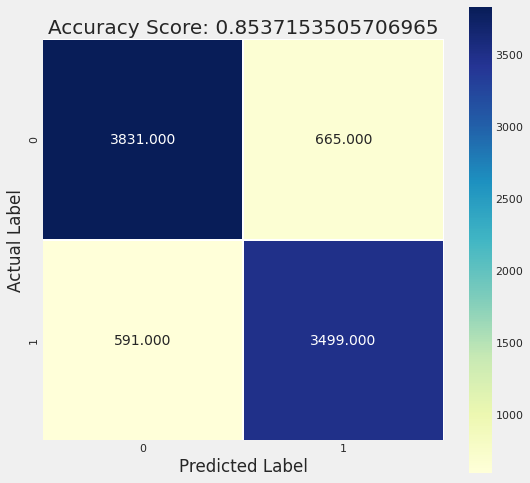

In [51]:
# Confusion Matrix

cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap="YlGnBu")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title, size = 20)

### Inferences:-
### 1. 665 labels are wrongly classified in unsarcastic headlines
### 2. 591 labels are wrongly classified in sarcastic headlines.

In [48]:
# Classification Report
print(classification_report(y_test, predictions, target_names = ['Unsarcastic','Sarcastic']))

              precision    recall  f1-score   support

 Unsarcastic       0.87      0.85      0.86      4496
   Sarcastic       0.84      0.86      0.85      4090

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586



### Inference:- f1-score for unsarcatic is slightly better than sarcastic. Also compared to previous model the f1-score has reduced by 0.01.

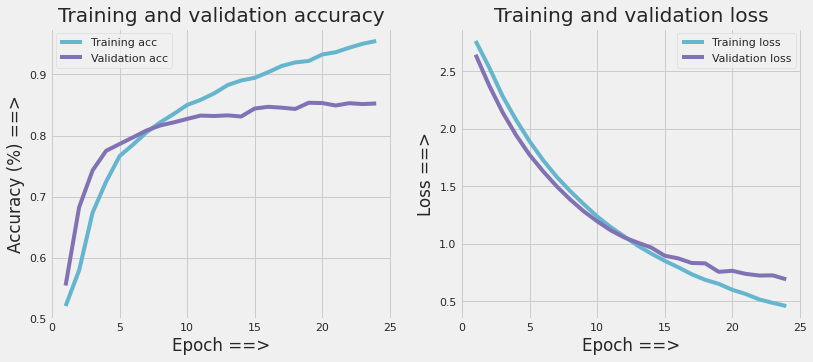

In [49]:
plot_history(history)

### Inferences:-
### 1. This model is only little overfitting. Compared to the previous base model, this one has improved drastically.
### 2. Training and Validation has good learning rate.
### 3. This model is better amongst the two.

# Conclusion:-
## 1. The first model is highly overfitting whereas second model is only little overfitting.
## 2. f1-score is only reducing by little in second model.
## 3. Difference between wronlgy classified labels has reduced in the second model.
## 4. To increase f1-score or accuracy further without overfiitting the model more data is necessary.